In [190]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

<ipython-input-190-736f187fe7ff>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [191]:
x=pd.read_csv('Book2.csv')
df1=pd.DataFrame(x)


In [192]:
#tock_name = 'GOOGL'
#df = get_stock_data(stock_name,0)
df1.tail()

,Open,High,Low,Close,Adj Close,Volume
242,76.13,77.45,75.38,77.39,77.00,158929200
243,78.04,78.99,75.80,76.91,76.53,200622400
244,79.46,79.92,77.73,77.85,77.46,162301200
245,77.03,79.26,76.81,78.75,78.36,145946400
246,76.41,77.59,76.07,77.53,77.14,133838400


In [193]:
df=df1.drop(columns=['Low','Adj Close', 'Volume'],axis=1)


In [194]:
today = datetime.date.today()
file_name = stock_name+'_stock_%s.csv' % today
df.to_csv(file_name)

In [195]:
df['High'] = df['High'] / 1000
df['Open'] = df['Open'] / 1000
df['Close'] = df['Close'] / 1000
df.head(5)

,Open,High,Close
0,0.13178,0.13356,0.13146
1,0.13647,0.13707,0.13348
2,0.13431,0.13502,0.13358
3,0.13501,0.13541,0.13439
4,0.13483,0.13506,0.13472


In [196]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.to_numpy() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [197]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [198]:
window = 10
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (212, 10, 3)
y_train (212,)
X_test (24, 10, 3)
y_test (24,)


In [199]:
model = build_model2([3,window,1])

<ipython-input-197-866b5e5b8a6c>:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  model.add(Dense(16,init='uniform',activation='relu'))
<ipython-input-197-866b5e5b8a6c>:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  model.add(Dense(1,init='uniform',activation='relu'))


In [200]:
model.fit(
    X_train,
    y_train,
    batch_size=256,
    nb_epoch=200,
    validation_split=0.1,
    verbose=0)

<ipython-input-200-59a1dfa8b787>:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(


In [201]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.01 RMSE)
Test Score: 0.00 MSE (0.00 RMSE)


In [202]:
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

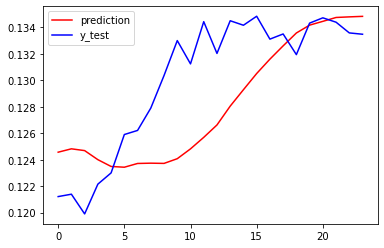

In [203]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()